# Startup

In [1]:
# @title --=== RUN TO START ===-- (Imports and Definitions)
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.keras import TqdmCallback
from keras.callbacks import Callback


SHEET_ID = '1OdllC9j05ka_adHvipTn58XPqmLt5f1VLBzHFd9aRJQ'
SHEET_NAME = 'GoL'
SLEEP = 1.5

# Board test parameters:
TARGET_MSE = 5*10**-6
EPOCHS = 7500
N_SEEDS = 100
LEARNING_RATE = 0.0025
OPTIMIZER_NAME = 'Adam'

results = {1: {}, 2: {}}


def get_filter_coords(point_coords):
  """
  x0y0 xiy0 x2y0
  x0yi xiyi x2yi
  x0y2 xiy2 x2y2
  """
  xi, yi = point_coords

  x0 = xi - 1
  x2 = xi + 1
  y0 = yi - 1
  y2 = yi + 1

  ul = (x0, y0)  # upper left
  uc = (xi, y0)  # upper center
  ur = (x2, y0)  # upper right
  ml = (x0, yi)  # middle left
  #mc = (xi, yi)  # middle center
  mr = (x2, yi)  # middle right
  ll = (x0, y2)  # lower left
  lc = (xi, y2)  # lower center
  lr = (x2, y2)  # lower right

  filter_coords = ul, uc, ur, ml, mr, ll, lc, lr

  return filter_coords


def read_coord(board, coord):
  shape_y, shape_x = board.shape
  xi, yi = coord
  if (xi < 0) or (yi < 0):
    return 0
  if (xi >= shape_x) or (yi >= shape_y):
    return 0
  return board[xi][yi]


def read_filter(board, filter_coords):
  for coord in filter_coords:
    yield read_coord(board, coord)


def play_a_cell(board, cell_coords):
  initial_state = read_coord(board, cell_coords)
  filter_coords = get_filter_coords(cell_coords)
  sum_neighbours = sum(read_filter(board, filter_coords))
  if sum_neighbours == 3:
    return 1
  if sum_neighbours == 2:
    return initial_state
  return 0


def play(board, padding=0, show=False) -> pd.DataFrame:
  shape_y, shape_x = board.shape
  result  = pd.DataFrame(
      np.zeros((shape_y-2*padding, shape_x-2*padding), dtype=int)
      )
  for xi in range(padding, shape_x-padding):
    for yi in range(padding, shape_y-padding):
      result[xi-padding][yi-padding] = play_a_cell(board, [xi, yi])
  if show:
    plt.imshow(result)
    plt.title(f'Board {np.array(board.shape)-2*padding}, {padding=}.')
    plt.show()
  return result


def play_n_steps(board, steps, padding=0, show=False):
    result = play(board, padding=padding, show=show)
    for i in range(steps - 1):
        result = play(result, padding=padding, show=show)
    return result


def load_board(sheet_id=SHEET_ID, sheet_name=SHEET_NAME, show=False):
  google_sheets_url = 'https://docs.google.com/spreadsheets/d/'
  google_sheets_url += f'{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
  board = pd.read_csv(google_sheets_url, header=None)
  if show:
    plt.imshow(board)
    plt.title(f'Game of Life Board. {board.shape=}')
    plt.show()
  return board


def generate_board(
    shape,
    padding=False,
    pad_value=0,
    levels=5,
    regulate_extreme_cases=False,
    show=False):
  """
  'outer' padding surrounds the array with zeros explicitly
  the shape of the board changes (+2 to each dimension)
  padding at conv2d layer is meant to be set to 'valid'
  """
  if levels:
    choice_ = np.random.randint(0, 1+1, levels)
    if regulate_extreme_cases:
      choice_ = np.concatenate([[0, 1], choice_])
    rand_array = np.random.choice(choice_, shape)
  else:
    rand_array = np.random.randint(0, 1+1, shape)
  if padding:
    assert padding == 'outer', 'padding must be either "outer" or None'
  if padding == 'outer':
    rand_array = np.pad(
        rand_array, 1, mode='constant', constant_values=pad_value)
  rand_board = pd.DataFrame(rand_array)
  if show:
    plt.imshow(rand_board)
    plt.title(f'Randomized board {shape}, {levels=}, {regulate_extreme_cases=}.')
    plt.show()
  return rand_board


def Xy_from_preset_5x5_patches(n_steps, shuffle=True):
  bantik1 = np.array([
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,1,0,1,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
  ])
  bantik2 = np.array([
      [0,0,0,0,0],
      [0,1,0,1,0],
      [0,0,0,0,0],
      [0,1,0,1,0],
      [0,0,0,0,0],
  ])
  bantik3 = np.array([
      [0,0,0,0,0],
      [0,0,1,0,0],
      [0,1,1,1,0],
      [0,0,1,0,0],
      [0,0,0,0,0],
  ])
  bantik4 = np.array([
      [0,0,0,0,0],
      [0,1,0,1,0],
      [0,0,1,0,0],
      [0,1,0,1,0],
      [0,0,0,0,0],
  ])
  palka = np.array([
      [0,0,0,0,0],
      [0,0,0,0,0],
      [0,1,1,1,0],
      [0,0,0,0,0],
      [0,0,0,0,0],
  ])
  alive1 = np.array([
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,0,0,1],
  ])
  alive2 = np.array([
      [1,0,1,0,1],
      [0,1,0,1,0],
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,1,0,1],
  ])
  alive3 = np.array([
      [0,1,0,1,0],
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,1,0,1],
      [0,0,1,0,0],
  ])
  dotted1 = np.array([
      [0,1,0,1,0],
      [1,0,1,0,1],
      [0,1,0,1,0],
      [1,0,1,0,1],
      [0,1,0,1,0],
  ])
  dotted2 = np.array(
      [
        [1,0,1,0,1],
        [0,1,0,1,0],
        [1,0,1,0,1],
        [0,1,0,1,0],
        [1,0,1,0,1],
      ]
  )
  infinistick = np.array(
      [
        [1,1,0,1,1],
        [0,0,0,0,0],
        [1,1,1,1,1],
        [0,0,0,0,0],
        [1,1,0,1,1],
      ]
  )
  extra = np.array(
      [
        [0,1,1,1,1],
        [1,0,1,0,1],
        [1,1,0,1,1],
        [1,0,0,0,1],
        [1,1,1,1,0],
      ]
  )
  empty = np.zeros([5,5]).astype(int)

  X_train = np.concatenate(
    [
      list(np.tile(bantik1, (1, 1, 1))),
      list(np.tile(bantik2, (1, 1, 1))),
      [bantik3],
      [bantik4],
      [alive1],
      [alive2],
      [alive3],
      [dotted1],
      [dotted2],
      [infinistick],
      [infinistick.T],
      [extra],
      [extra.T],
      [empty]
    ]
  )
  if shuffle:
    np.random.shuffle(X_train)
  padding = -1
  y_train = [
      play_n_steps(pd.DataFrame(i), n_steps, padding=padding) for i in X_train
  ]
  X_train_ready = np.pad(X_train, n_steps)[n_steps:-n_steps]
  y_train_ready = np.array(y_train)
  return X_train, y_train, X_train_ready, y_train_ready


# minimal model with fixed init
def get_minimal_model(seed):
  tf.random.set_seed(seed)

  n_filters = 2
  kernel_size = (3, 3)
  input_shape = (None, None, 1)

  input_layer = tf.keras.layers.Input(shape=input_shape)

  conv2d_layer = tf.keras.layers.Conv2D(
      filters=n_filters,
      kernel_size=kernel_size,
      activation='tanh',
      use_bias=True,
      padding='same',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(input_layer)

  output_layer = tf.keras.layers.Conv2D(
      filters=1,
      kernel_size=(1, 1),
      use_bias=True,
      activation='relu',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(conv2d_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  tf.keras.utils.plot_model(model)
  return model


def get_core_model_zp(seed):
  tf.random.set_seed(seed)

  n_filters = 2
  kernel_size = (3, 3)
  input_shape = (None, None, 1)

  input_layer = tf.keras.layers.Input(shape=input_shape)
  zero_padding_layer = tf.keras.layers.ZeroPadding2D()(input_layer)

  conv2d_layer = tf.keras.layers.Conv2D(
      filters=n_filters,
      kernel_size=kernel_size,
      activation='tanh',
      use_bias=True,
      bias_initializer=tf.keras.initializers.Constant(0),
      padding='valid',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(zero_padding_layer)

  output_layer = tf.keras.layers.Conv2D(
      filters=1,
      kernel_size=(1, 1),
      use_bias=True,
      bias_initializer=tf.keras.initializers.Constant(0),
      activation='relu',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(conv2d_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  tf.keras.utils.plot_model(model)
  return model


def x4_mirror(df, show=False):
  x4 = np.array(df)
  x4 = np.concatenate(
          [
              x4,
              np.flip(x4, axis=0)
          ],
          axis=0
      )
  x4 = np.concatenate(
          [
              x4,
              np.flip(x4, axis=1)
          ],
          axis=1
      )
  if show:
      plt.imshow(x4)
      plt.title('X4 Mirror')
      plt.show()
  return pd.DataFrame(x4)


class RecursiveModel(tf.keras.models.Model):
  def __init__(self, core_model, n_times, **kwargs):
      super().__init__(**kwargs)
      self.core_model = core_model
      self.n_times = n_times

  def call(self, inputs):
      x = inputs
      for _ in range(self.n_times):
          x = self.core_model(x)
      return x


def cpt(model_name, models_folder='models', ext='hdf5'):  
  filepath = f'{models_folder}/{model_name}.{ext}'
  return tf.keras.callbacks.ModelCheckpoint(
      filepath,
      monitor='loss',
      verbose=0,
      save_best_only=True,
      save_weights_only=True,
      mode='auto',
      save_freq='epoch',
      initial_value_threshold=None,
      options=None
  )


class EarlyStoppingByLoss(Callback):
    def __init__(self, value, monitor='loss', verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current:
            if current <= self.value:
                if self.verbose:
                    print("Epoch %05d: early stopping THR" % epoch)
                self.model.stop_training = True


class BoardTest:
    def __init__(
        self,
        n_steps,
        board_name,
        x4=False,
        seeds=None,
        epochs=EPOCHS,
        n_seeds=N_SEEDS,
        target_mse=TARGET_MSE,
        optimizer_name=OPTIMIZER_NAME,
        learning_rate=LEARNING_RATE,
        new_model=True
    ):
        self.n_steps = n_steps
        self.board_name = board_name
        self.x4 = x4
        self.epochs = epochs
        self.optimizer_name = optimizer_name
        self.learning_rate = learning_rate
        self.target_mse = target_mse
        self.new_model = new_model

        self.models = {}
        self.losses = {}
        self.loss_histories = {}
        self.okays = {}

        self.seeds = seeds
        if self.seeds is None:
            self.n_seeds = n_seeds
            self.seeds = range(self.n_seeds)
        else:
            self.n_seeds = len(self.seeds)

        self.X_train = load_board(sheet_name=board_name, show=True)
        if self.x4:
            self.X_train = x4_mirror(self.X_train, show=True)
        self.y_train = play_n_steps(self.X_train, self.n_steps, show=True)
        self.X_train_ready = np.array(self.X_train)[None, ..., None]
        self.y_train_ready = np.array(self.y_train)[None, ...]

        self.early_stop = EarlyStoppingByLoss(
            value=self.target_mse,
            monitor='loss',
            verbose=False
        )  

    def run_seed(self, seed, epochs, optimizer_name, learning_rate, new=True):
        tf.random.set_seed(seed)        
        model_name = f'{self.n_steps}_steps_{self.board_name}_seed_{seed}'
        model_path = f'models/{model_name}.hdf5'
        if new:
          model = get_minimal_model(seed)
        else:
          model = tf.keras.models.load_model(model_path) 
        recursive_model = RecursiveModel(core_model=model, n_times=self.n_steps)
        optimizers = {
            'Adafactor': tf.keras.optimizers.Adafactor(learning_rate=learning_rate),
            'Adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
            'Adamax': tf.keras.optimizers.Adamax(learning_rate=learning_rate),
            'AdamW': tf.keras.optimizers.AdamW(learning_rate=learning_rate),
            'Nadam': tf.keras.optimizers.Nadam(learning_rate=learning_rate),
        }               
        model.compile(optimizer=optimizers[optimizer_name], loss='mse')        
        recursive_model.compile(optimizer=optimizers[optimizer_name], loss='mse')
        history = recursive_model.fit(
            self.X_train_ready,
            self.y_train_ready,
            epochs=epochs,
            batch_size=1,
            verbose=False,
            callbacks=[
                cpt(model_name),
                TqdmCallback(verbose=True),
                self.early_stop
                ]
        )
        if not os.path.exists(model_path):
            model.save(model_path)
        loss = history.history['loss']
        label = f'Seed {seed}. Loss = {loss[-1]}'
        plt.plot(loss, label=label)
        return model, loss

    def __call__(self):      
        for seed in self.seeds:
            model, loss = self.run_seed(
                seed,
                epochs=self.epochs,
                optimizer_name=self.optimizer_name,
                learning_rate=self.learning_rate,
                new=self.new_model
            )
            self.models[seed] = model
            self.loss_histories[seed] = loss
            self.losses[seed] = loss[-1]
            if loss[-1] <= self.target_mse:
                self.okays[seed] = True
            else:
                self.okays[seed] = False
        performance = 100 * sum(self.okays.values()) / len(self.okays)
        title = f'{self.n_steps}-Step on {self.board_name}.'
        title += f'{self.optimizer_name} {self.epochs} epochs.'
        title += f' {performance:.1f}% success'
        plt.title(title)
        plt.legend()
        plt.show()
        results_filename = f'boards_vs_seeds_{self.n_steps}_step_{self.epochs}_epochs.csv'
        write_header = False if os.path.exists(results_filename) else True
        losses_df = pd.DataFrame(self.losses, index=[self.board_name])
        losses_df.to_csv(results_filename, mode='a', header=write_header)        
        return losses_df

# Comparing Optimizers

In [13]:
GOOD_OPTIMIZERS = [
    'Adafactor',
    'Adam',
    'Adamax',
    'AdamW',
    'Nadam'
]    

## 2-Step Board Ones X4

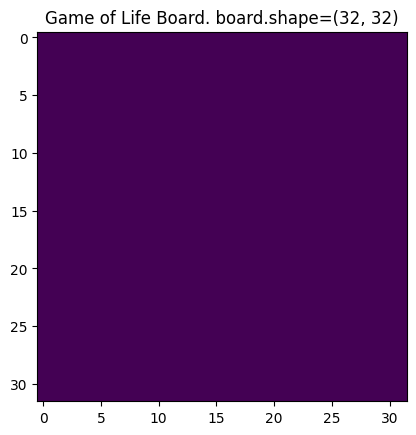

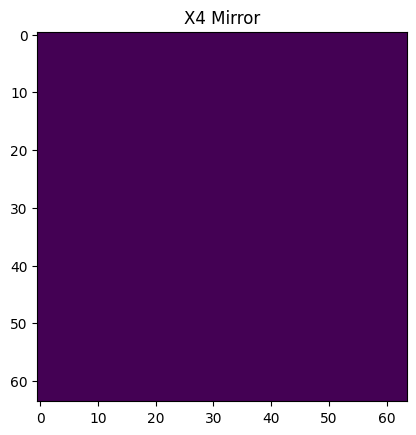

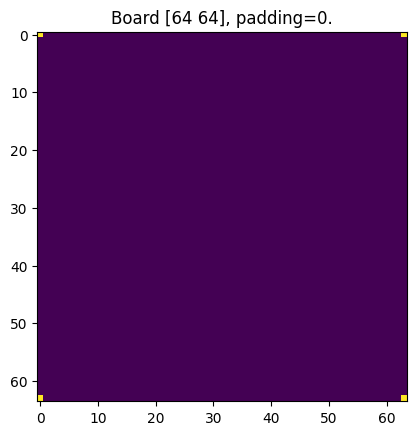

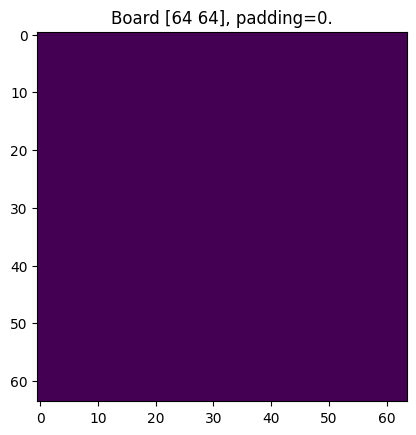

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

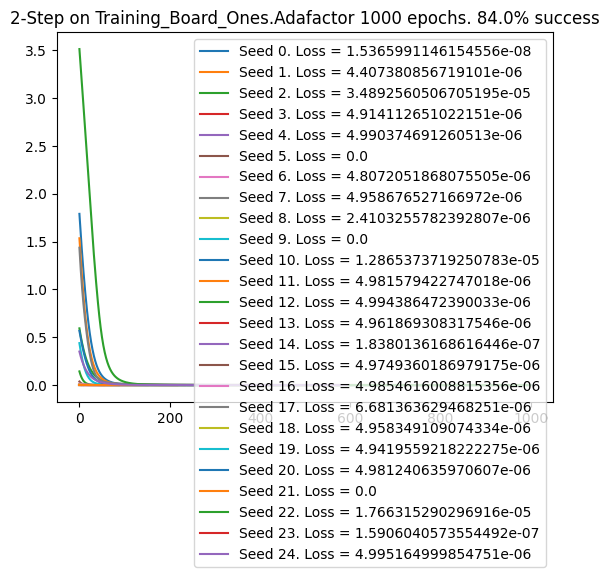

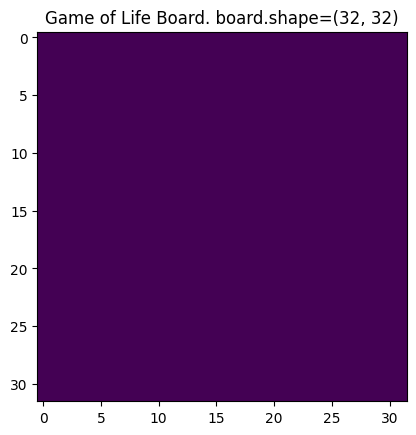

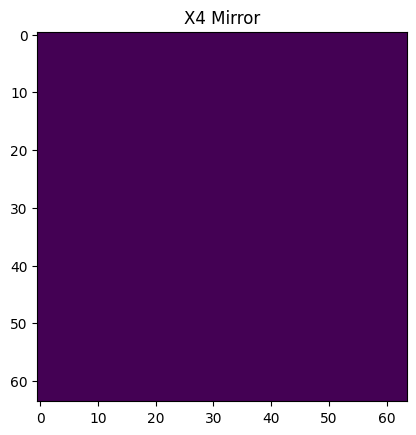

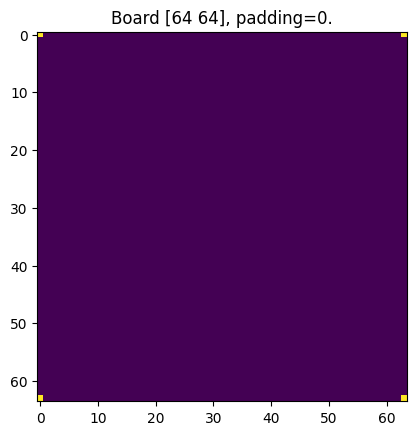

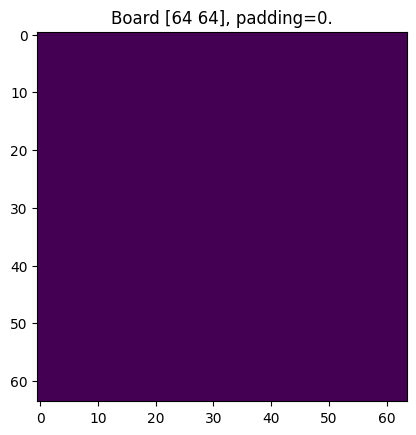

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

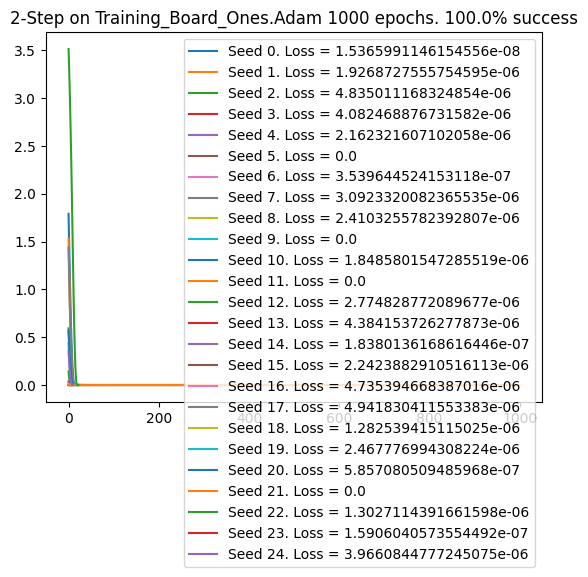

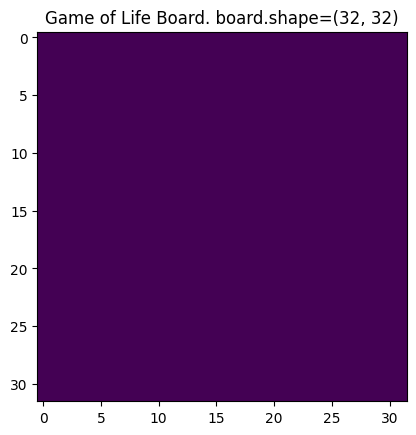

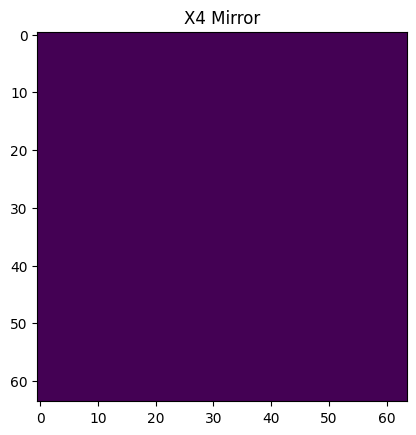

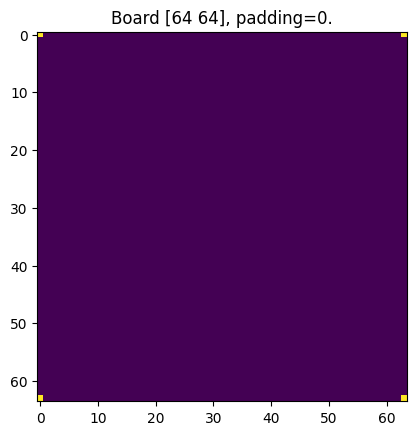

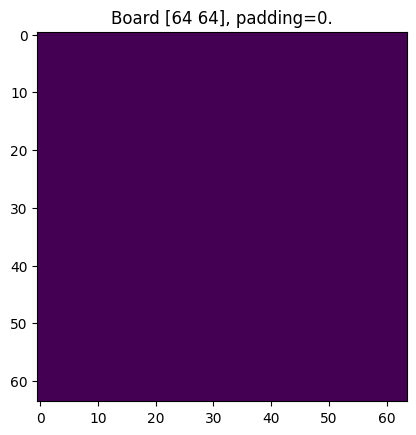

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

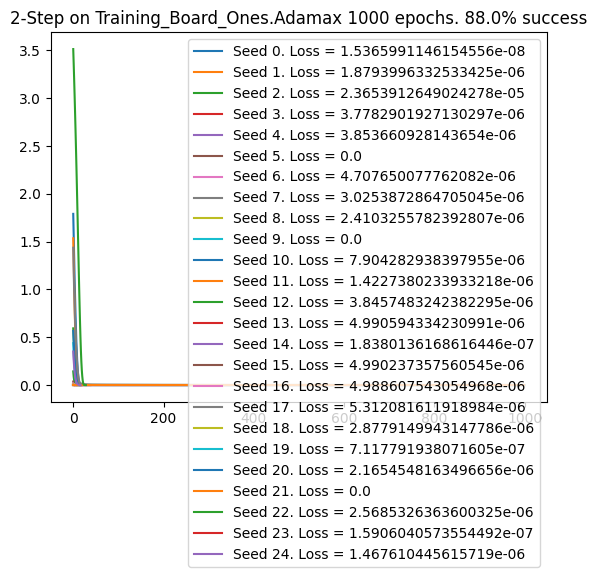

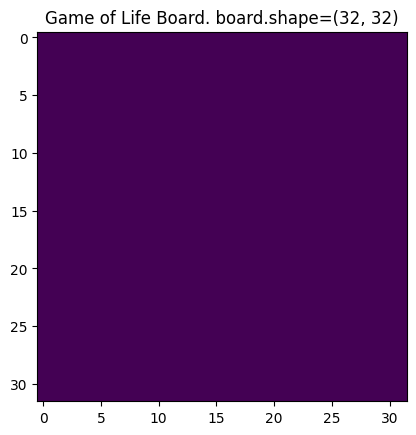

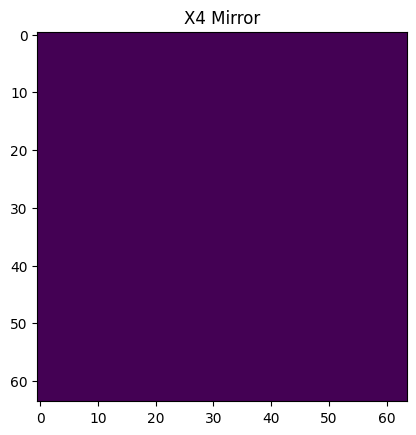

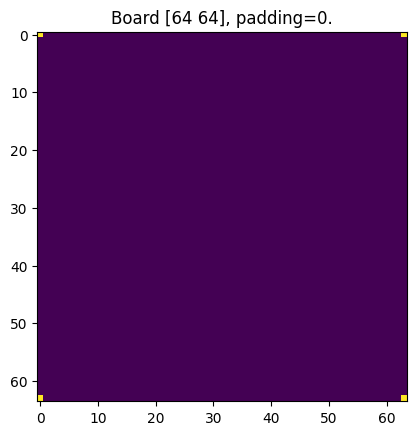

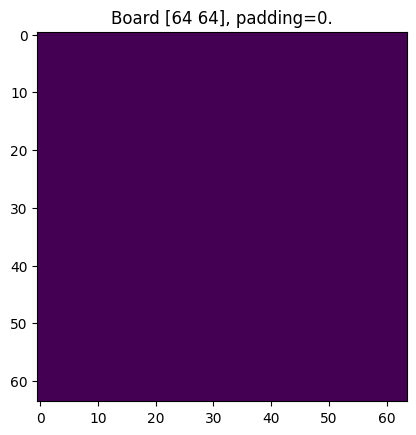

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

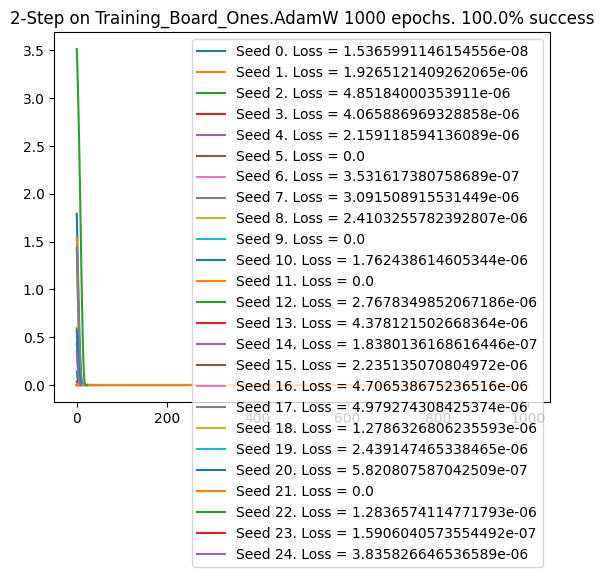

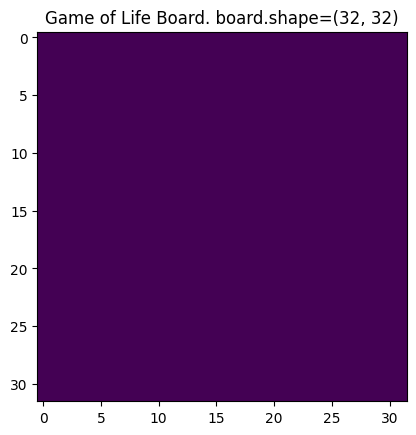

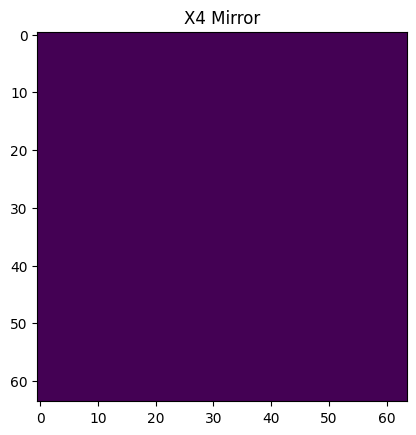

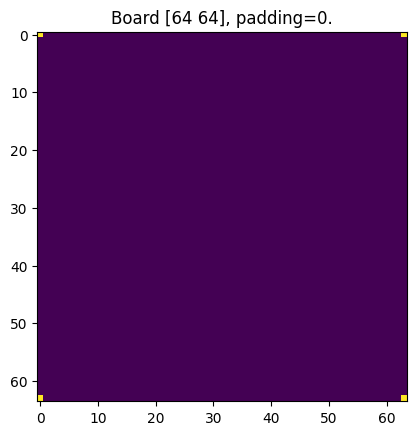

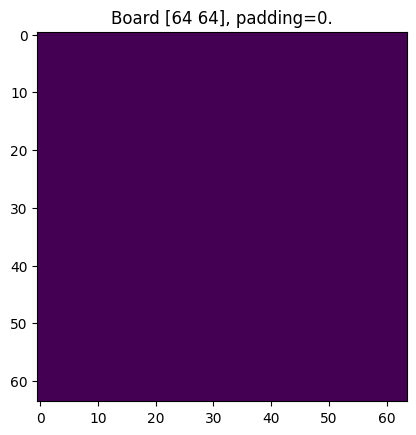

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

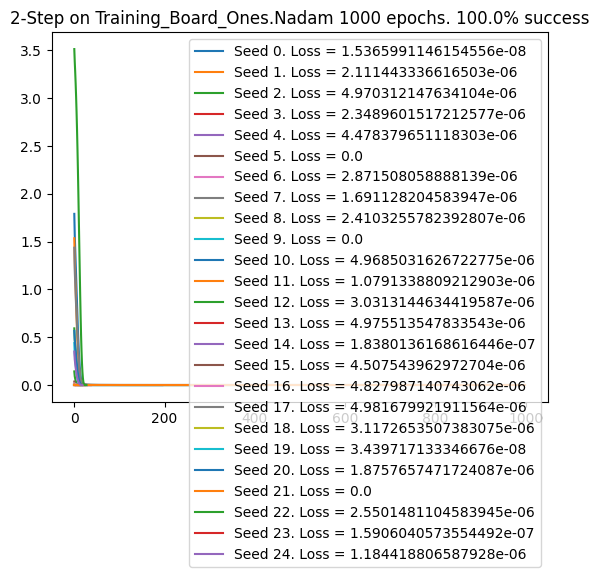

In [16]:
for optimizer_name in GOOD_OPTIMIZERS:
    BoardTest(n_steps=2, board_name='Training_Board_Ones', x4=True, seeds=None, n_seeds=25, optimizer_name=optimizer_name, learning_rate=0.005, epochs=1000)()

### Ones, % success

In [18]:
optimizers_df = pd.read_csv('Ones 25 seeds for Adafactor Adam Adamax AdamW Nadam.csv').drop(columns='Unnamed: 0')
optimizers_df.index = GOOD_OPTIMIZERS
optimizers_df = optimizers_df.T
(optimizers_df <= TARGET_MSE).mean() * 100

Adafactor     84.0
Adam         100.0
Adamax        88.0
AdamW        100.0
Nadam        100.0
dtype: float64

In [19]:
optimizers_df.sum()

Adafactor    0.000144
Adam         0.000050
Adamax       0.000087
AdamW        0.000049
Nadam        0.000058
dtype: float64

## 2-Step Board Zeros X4

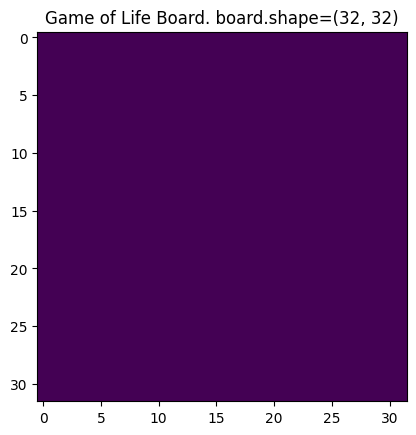

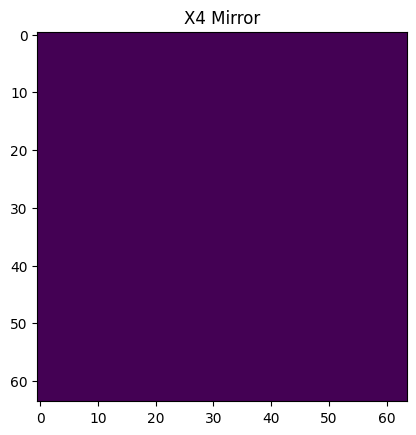

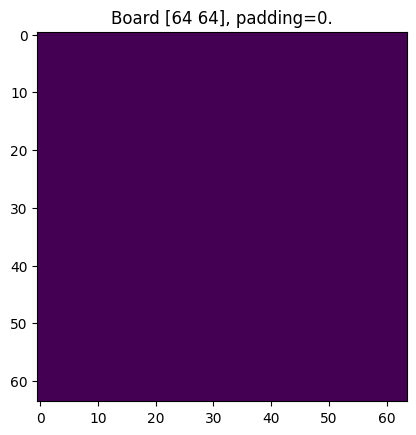

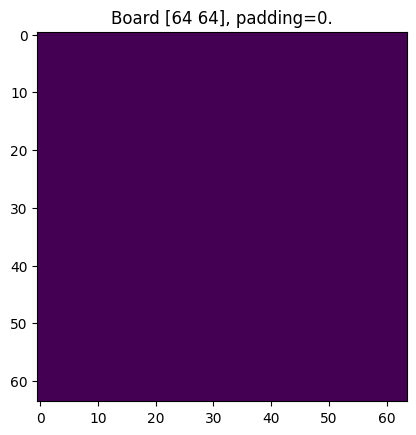

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

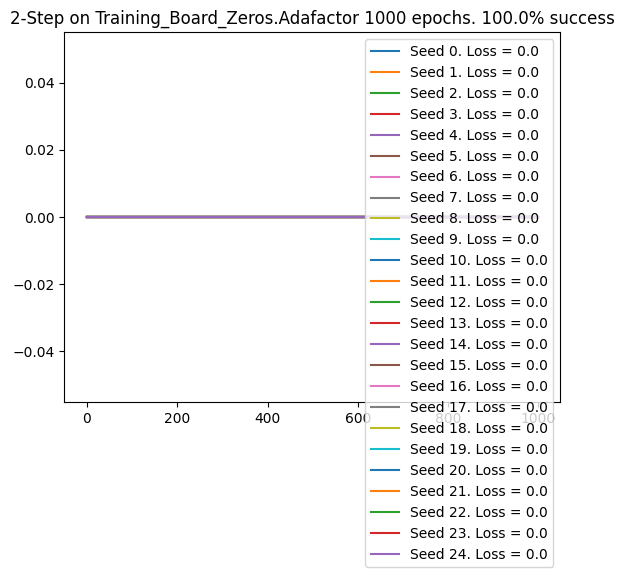

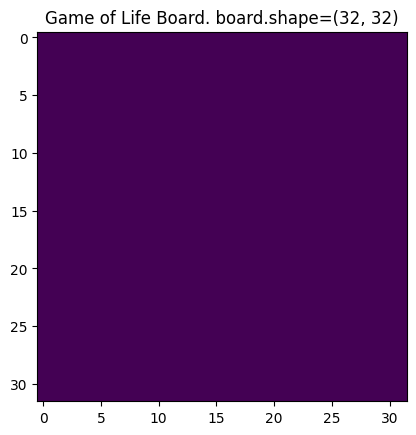

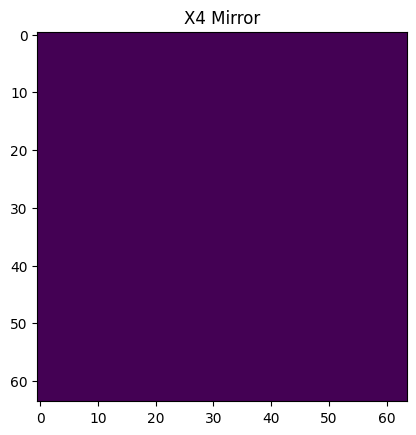

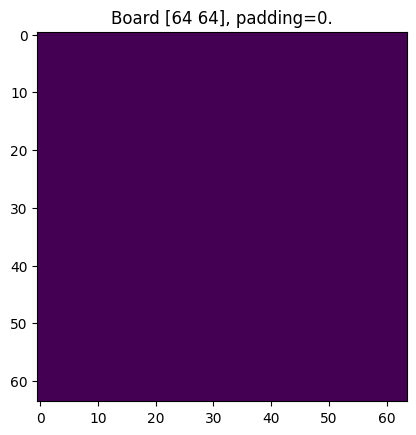

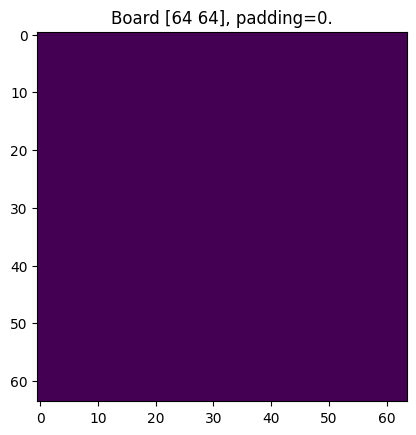

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

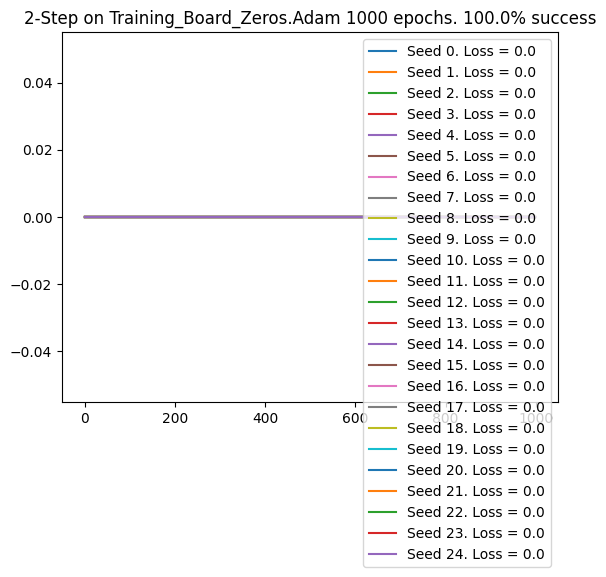

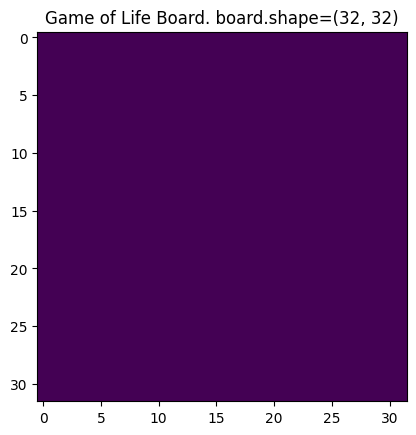

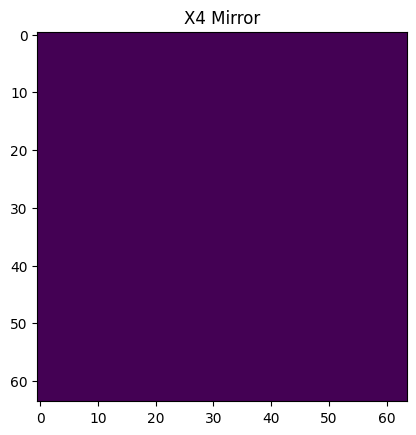

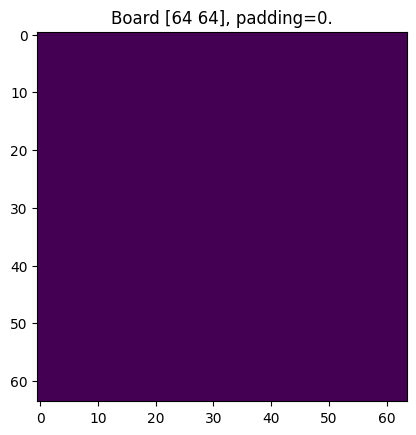

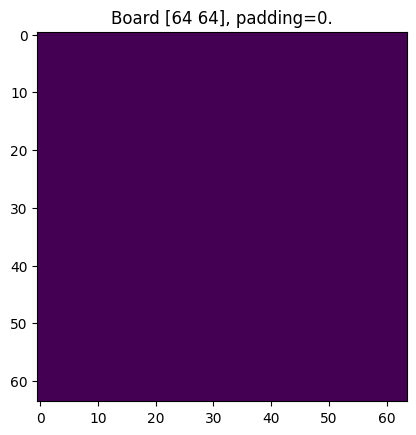

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

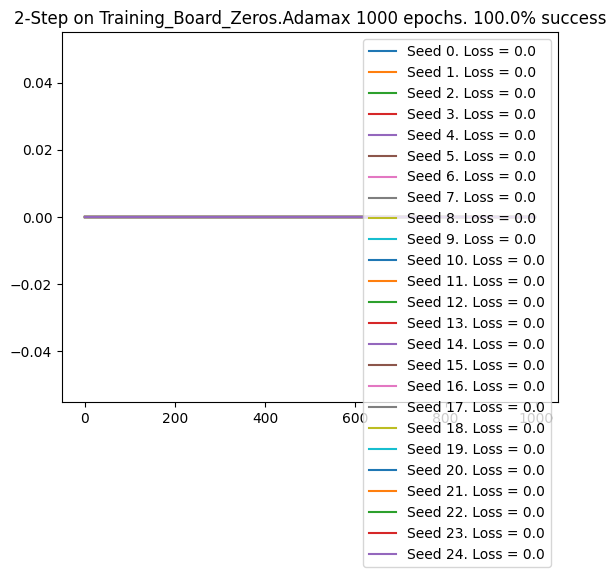

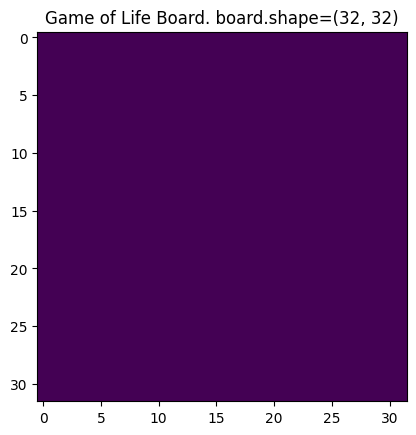

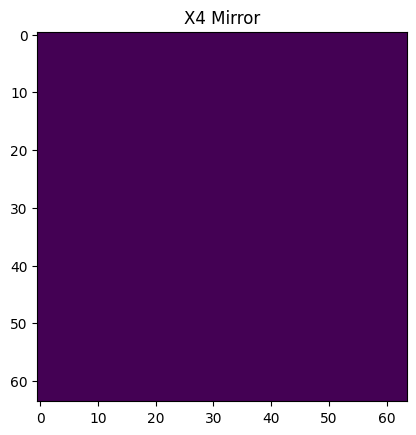

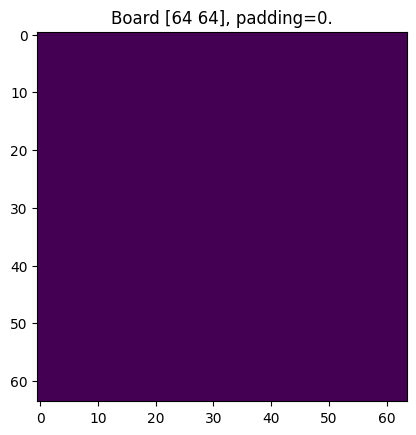

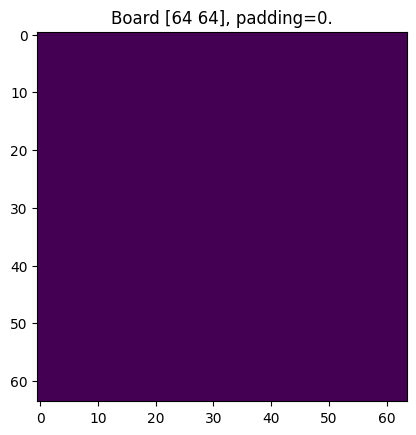

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

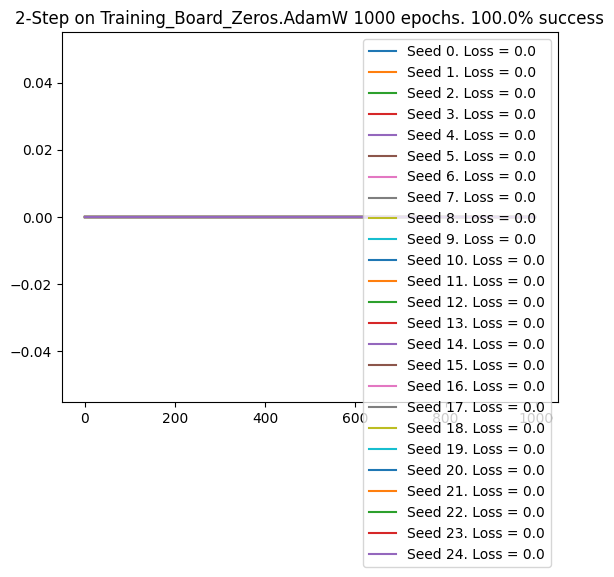

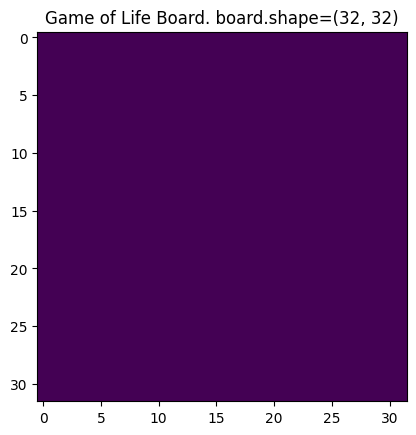

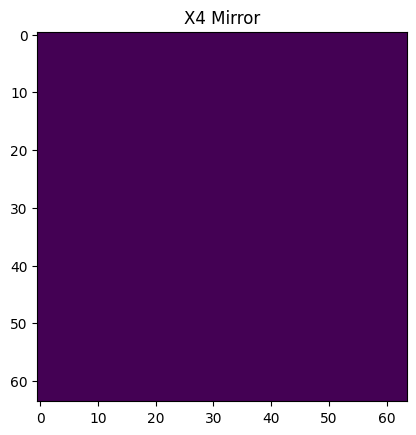

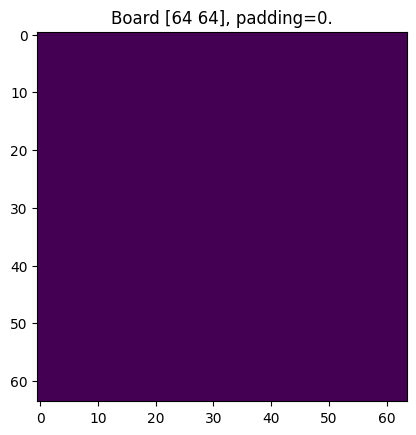

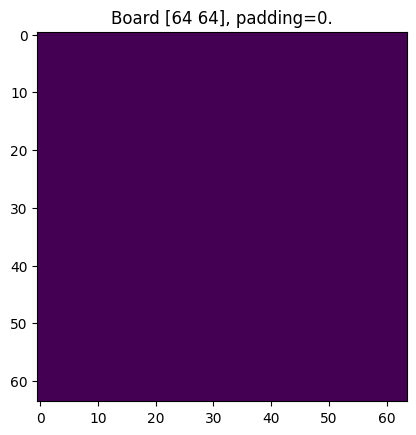

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

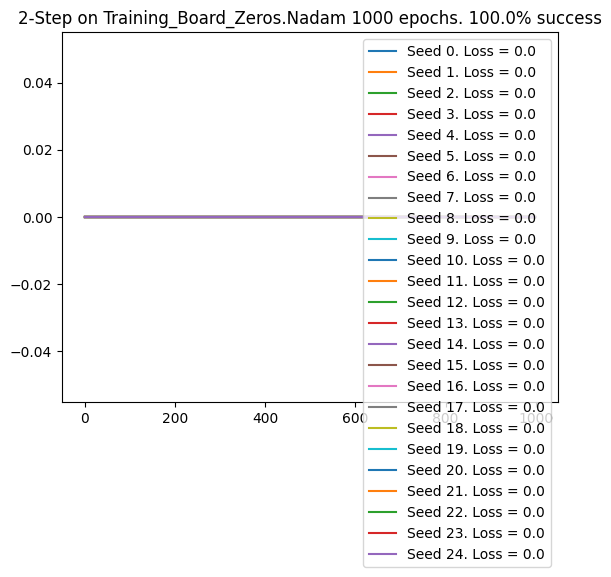

In [20]:
for optimizer_name in GOOD_OPTIMIZERS:
    BoardTest(n_steps=2, board_name='Training_Board_Zeros', x4=True, seeds=None, n_seeds=25, optimizer_name=optimizer_name, learning_rate=0.005, epochs=1000)()

### Zeros, % success

In [21]:
optimizers_df = pd.read_csv('Zeros 25 seeds for Adafactor Adam Adamax AdamW Nadam.csv').drop(columns='Unnamed: 0')
optimizers_df.index = GOOD_OPTIMIZERS
optimizers_df = optimizers_df.T
(optimizers_df <= TARGET_MSE).mean() * 100

Adafactor    100.0
Adam         100.0
Adamax       100.0
AdamW        100.0
Nadam        100.0
dtype: float64

In [22]:
optimizers_df.sum()

Adafactor    0.0
Adam         0.0
Adamax       0.0
AdamW        0.0
Nadam        0.0
dtype: float64

# Board Tests

## 2-Step Board 12 X4

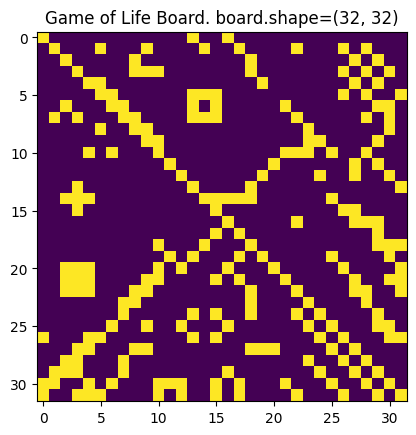

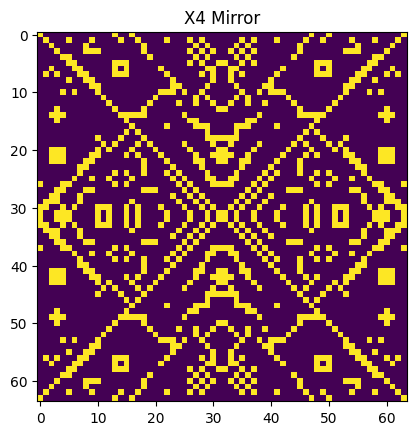

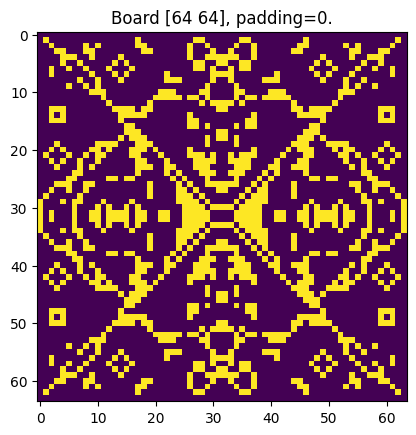

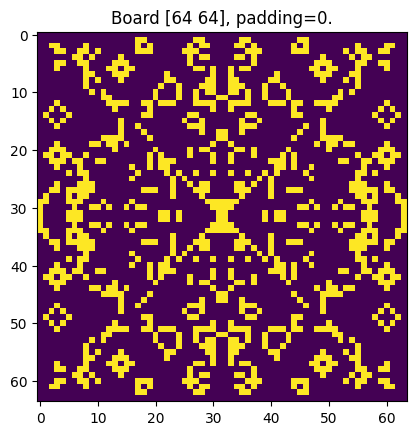

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [2]:
N_STEPS = 2
BOARD_NAME = 'Training_Board_12'
results[N_STEPS][BOARD_NAME] = BoardTest(
    n_steps=N_STEPS,
    board_name=BOARD_NAME,
    x4=True,
    seeds=None,
    n_seeds=10,
    optimizer_name='AdamW',
    learning_rate=0.0025
    )()

## 2-Step Board 13f X4

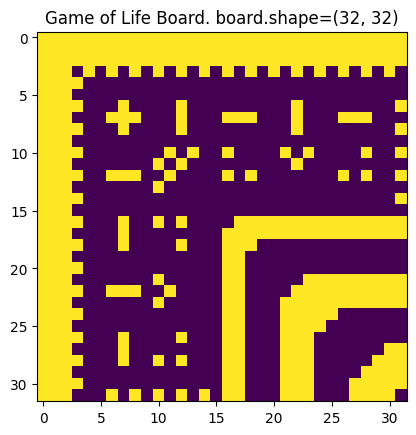

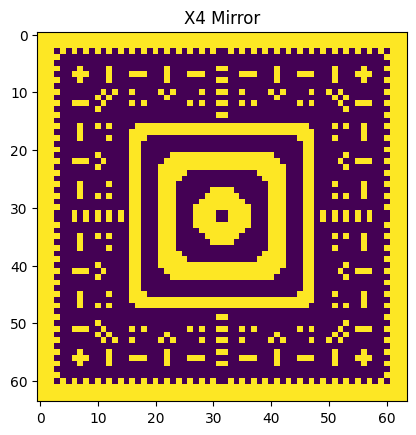

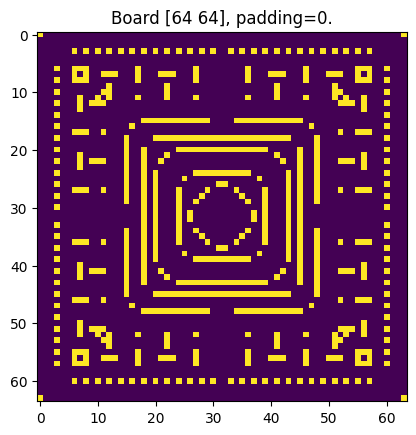

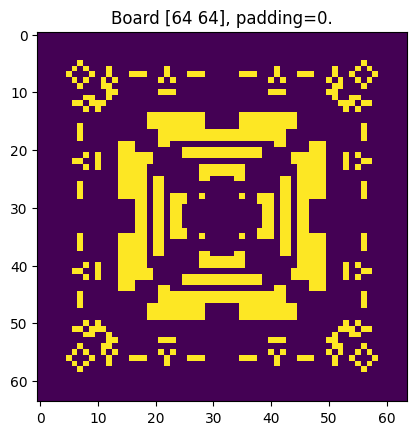

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

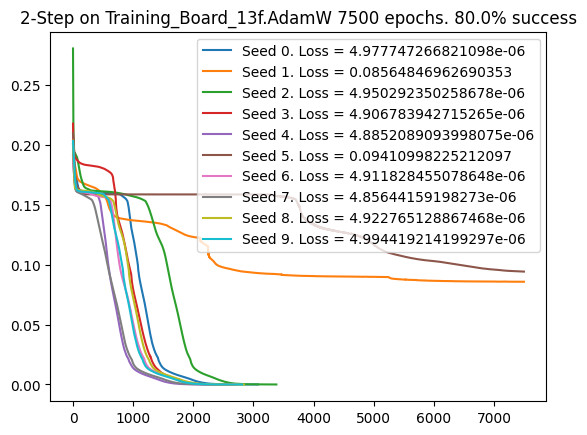

In [18]:
N_STEPS = 2
BOARD_NAME = 'Training_Board_13f'
results[N_STEPS][BOARD_NAME] = BoardTest(
    n_steps=N_STEPS,
    board_name=BOARD_NAME,
    x4=True,
    seeds=None,
    n_seeds=10,
    optimizer_name='AdamW',
    learning_rate=0.0025
    )()

## 1-Step Board 13f

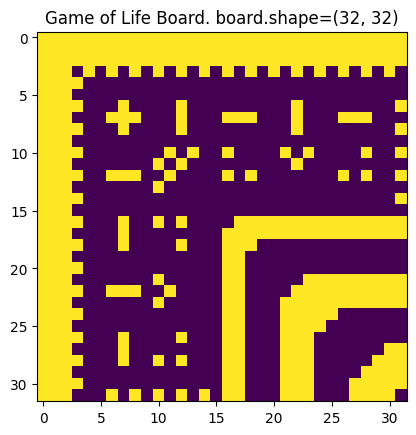

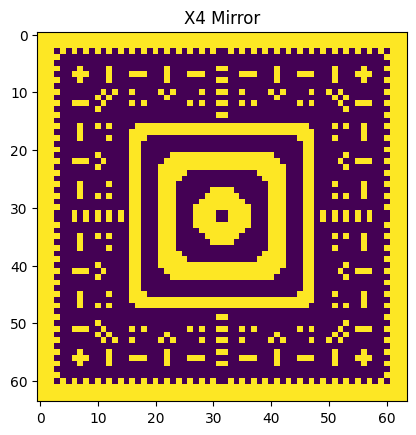

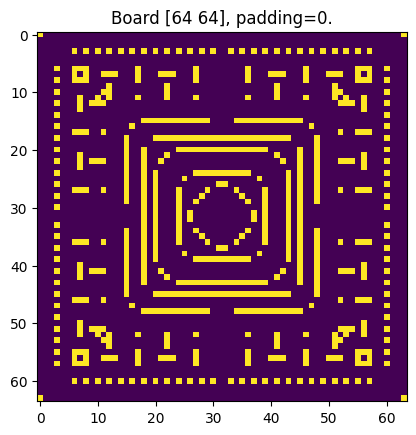

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

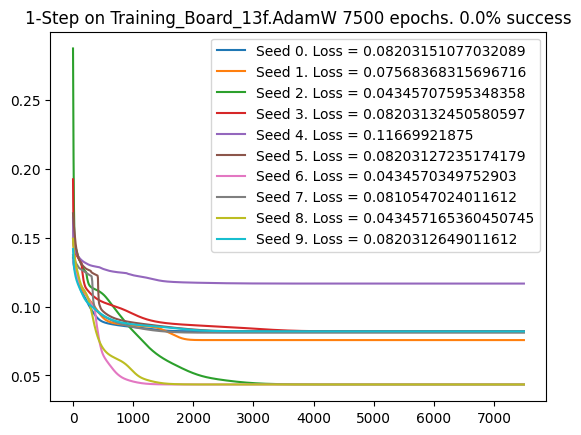

In [19]:
N_STEPS = 1
BOARD_NAME = 'Training_Board_13f'
results[N_STEPS][BOARD_NAME] = BoardTest(
    n_steps=N_STEPS,
    board_name=BOARD_NAME,
    x4=True,
    seeds=None,
    n_seeds=10,
    optimizer_name='AdamW',
    learning_rate=0.0025
    )()

## 1-Step Board 10

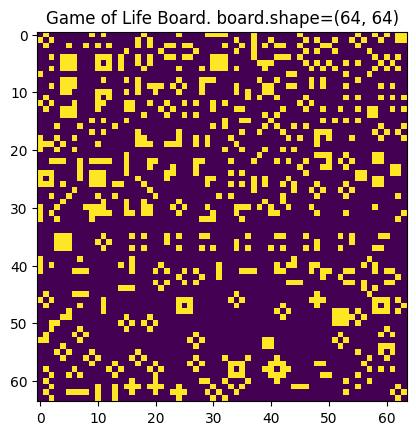

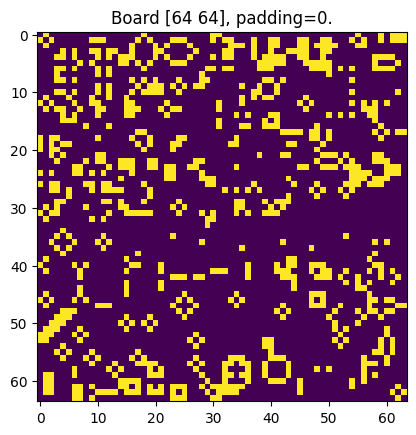

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

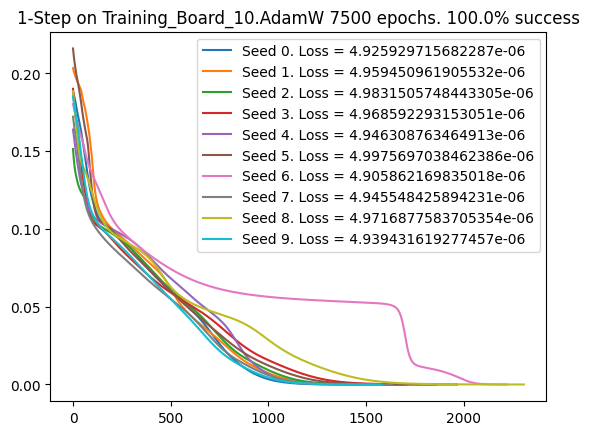

In [21]:
N_STEPS = 1
BOARD_NAME = 'Training_Board_10'
results[N_STEPS][BOARD_NAME] = BoardTest(
    n_steps=N_STEPS,
    board_name=BOARD_NAME,
    x4=False,
    seeds=None,
    n_seeds=10,
    optimizer_name='AdamW',
    learning_rate=0.0025
    )()

## Board 13g X4

### 1 Step

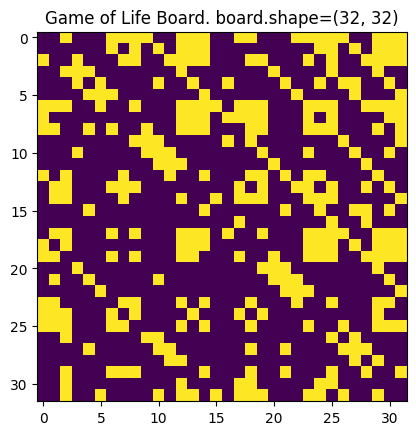

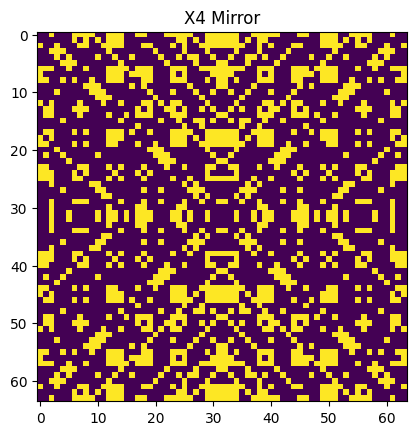

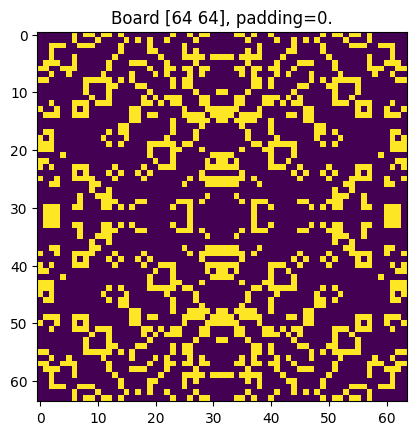

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [23]:
BoardTest(
    n_steps=1,
    board_name='Training_Board_13g',
    x4=True,
    seeds=None,
    n_seeds=100,
    optimizer_name='AdamW',
    learning_rate=0.0025
    )()

# ______________________